# 3' Rapid Amplification of cDNA Ends (RACE) of human telomerase (hTR) gene Analysis
    author: Morgan R Weichert
    email: morgan@baumannlab.org

###### Input dataset 

| Data         | Location                                       | Type   | Read Length | Lanes|
|-------------------|------------------------------------------------|--------|-------------|----|
| Seqence directory | /path/to/raw/data/| Paried |         RapidSeq-250 |2|

> The amplicons contain (from 5' to 3'):
- 10 nt Molecular Barcode: NNNNNNNNNN
    - barcode is for removing PCR duplicates/bias
- hTR-specific primer: CAGGAAGAGGAACGGAGCGAGT
- hTR insert sequence (variable ending position): CCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC
- ntna (non-templated nucleotide addition) sequence: variable length & sequence
    - ntna sequence includes polyA tails or any other sequence that is not the reference hTR sequence
- linker (adaptor) sequence: TTTAACCGCGAATTCCAG
    - the linker seq will be variable length depending on how long the hTR sequence is and how long the ntna sequence is
- AC-index
- P7 Adapter: ATCTCGTATGCCGTCTTCTGCTTG

###### import python packages

In [1]:
import os
import re
import json
import gzip
import glob
import dnaio
import regex
#import commands
import subprocess
import numpy as np
import pandas as pd
from Bio import Seq
from Bio import SeqIO
from itertools import repeat
from collections import Counter
from multiprocessing import Pool
work_dir = "/mnt/NFS/pisces/gcobs/project/HL23607/"
os.chdir(work_dir)

## raw reads to analysis ready reads

### create symbolic links to raw data
this saves space by pointing to the raw fastq files so that I don't need to copy them into my own directory

In [2]:
# %load /home/msr/general_scripts/create_symlinks_to_data.R
#!/n/apps/CentOS7/bin/Rscript

#################################################################################################
# R script for matching fastq names from machine (s_lane_read_index.fastq) 
# to the sample name given in the sample report (control_1) 
# and creates raw_data directory containing symbolic links to the renamed fastq files.
# The symbolic linked fastq files have renamed format samplename_lane_read.fastq

# This script is to be ran on the command line giving a directory to the raw data
# Example: $ create_symlinks_to_data.R /path/to/raw/data/
# This script also assumes there is a SampleReport.csv file in the given directory
# containg a column 'Output' and a column 'SampleNames'
#################################################################################################

args = commandArgs(trailingOnly = TRUE) # script expects arguments trailing
fc.dir <- args[1] # the first argument is the flowcell directory

################ parse sample report ############################################################
molng <- unlist(strsplit(fc.dir, '/'))[6] # this is the sequenced order ID

fqs <- list.files(fc.dir, "[ACGT].+\\.fastq\\.gz", full = TRUE) # list of the fastq files
#print(length(fqs)) # check number of samples matches

report <- read.csv(list.files(fc.dir, "Report\\.csv", full = TRUE)) # read in the SampleReport.csv
# subset the sample report to ony this sqeuencing order
# this is required because sometime multipe separate orders are sequenced together
report <- subset(report, report$Order == molng) 
#print(unique(report$SampleName)) # if you want to check the sample names

# match the sample name (control_1) to the machine name (s_lane_read_index)
samples <- as.character(report$SampleName[match(basename(fqs), report$Output)]) 
#print(unique(samples)) # check matching correctly

lanes <- as.character(report$Lane[match(basename(fqs), report$Output)]) # grab the corresponding lane
read <- as.character(report$Read[match(basename(fqs), report$Output)]) # grab the corresponding read 
                                                                      # (1 fw read, 2 rev read)
#####################################################################################################

# create file paths with new name format sample_lane_read
links <- file.path("raw_data",
                   paste0(paste(samples,lanes,read,sep="_"),".fastq.gz"))
# print(links) # check this works

####### create raw_data direcotry with create symlinks ################
dir.create("raw_data",FALSE,TRUE) # give FALSE if file alread exists    
file.symlink(fqs,links)
warnings()
#####################################################################################################


SyntaxError: invalid syntax (2575136798.py, line 28)

In [ ]:
#%%bash 
!conda env list
!Rscript create_symlinks_to_data.R /mnt/NFS/pisces/gcobs/test/race/data

### Raw Read Counts per Sample

In [ ]:
# %load /home/msr/general_scripts/count_reads_per_sample.py
#!/home/msr/bin/anaconda/bin/python

"""
python script for counting reads in fastq file
run on command line and specify (1) directory of fastq files and (2) output tsv file name
assumes sample naming convention of samplename_lane_read.fastq.gz
Example: 
$ count_number_single_reads_per_sample.py -indir ./raw_data/ -outfile raw_read_counts_per_sample.tsv
"""

import os
import re
import argparse
import commands
import pandas as pd

################################ set up user input ##############################################
parser = argparse.ArgumentParser(
    description='Count number of reads for each file in dir')
# define arguments
parser.add_argument('-indir', type=str, required=True,
                    help='input directory of gzipped fastq files')
parser.add_argument('-outfile', type=str, required=True,
                    help='path to tsv output file')
args = parser.parse_args()
#################################################################################################

df = pd.DataFrame()  # initialize dataframe

#################################################################################################
for i in os.listdir(args.indir): # for each file (i) in the given directory
    
    # here samples are named samplename_lane_read.fastq.gz
    sample_name = re.split(r'_([0-9])_([0-9]).fastq', i)[0]  # grap sample name
    read = re.split('_', re.split(r'.fastq', i)[0])[-1]  # grab read number (1=fw, 2=rev)
    lane = re.split('_', re.split(r'.fastq', i)[0])[-2]  # grab lane number

    # unix to count num lines in file
    lane_lines = commands.getoutput('zcat ' + args.indir + i + '| wc -l')
    # divide by 4 for to get number of reads for fastq files
    lane_reads = int(lane_lines) / 4.0

    # store in dataframe
    df = df.append({'lane_read': str('lane_' + lane + '_read_' + read),
                    'read_count': lane_reads,
                    'sample': sample_name},
                    ignore_index = True)

#################################################################################################

# reorganize dataframe
df = df.pivot_table(values  = 'read_count',
                    index   = ["sample"],
                    columns = ['lane_read'])

if len(df.columns) > 1: # if the sample was run on more than one lane compute a total
    df["total_reads"] = df.sum(axis=1)
# print df

# write dataframe to csv
df.to_csv(args.outfile,
          sep='\t',
          header=True,
          index=True,
          index_label=['sample'])


In [3]:
#%%bash

!./count_reads_per_sample.py -indir ./rawData/ -outfile raw_read_counts_per_sample.tsv

HeLa-Ctrl-1_1_1.fastq.gz
HeLa-Ctrl-3_1_1.fastq.gz
HeLa-LARP3-OE-0_1_1.fastq.gz
HeLa-LARP3-OE-1_1_1.fastq.gz
HeLa-LARP3-OE-3_1_1.fastq.gz
HeLa-LARP7-1_1_1.fastq.gz
HeLa-LARP7-2_1_1.fastq.gz
HeLa-LARP7-3_1_1.fastq.gz
HeLa-Luc-1_1_1.fastq.gz
HeLa-Luc-2_1_1.fastq.gz
HeLa-Luc-3_1_1.fastq.gz
HeLa-MePCE-1_1_1.fastq.gz
HeLa-MePCE-2_1_1.fastq.gz
HeLa-MePCE-3_1_1.fastq.gz
HeLa-PARN-1_1_1.fastq.gz
HeLa-PARN-2_1_1.fastq.gz
HeLa-PARN-3_1_1.fastq.gz
K562-C1-sh-Luc-1_1_1.fastq.gz
K562-C2-sh-Luc-2_1_1.fastq.gz
K562-C3-sh-Luc-3_1_1.fastq.gz
K562-S1-sh-LARP3-1_1_1.fastq.gz
K562-S2-sh-LARP3-2_1_1.fastq.gz
HeLa-Ctrl-0_1_1.fastq.gz
K562-S3-sh-LARP3-3_1_1.fastq.gz
        lane_read  read_count              sample
0   lane_1_read_1   4647244.0         HeLa-Ctrl-1
1   lane_1_read_1   5482956.0         HeLa-Ctrl-3
2   lane_1_read_1   5180856.0     HeLa-LARP3-OE-0
3   lane_1_read_1   6042016.0     HeLa-LARP3-OE-1
4   lane_1_read_1   5485480.0     HeLa-LARP3-OE-3
5   lane_1_read_1   5524452.0        HeLa-LARP7-1

In [4]:
# view raw read counts computed above
# pd.read_csv('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/raw_read_counts_per_sample.tsv', 
#             sep = '\t')
pd.read_csv('./raw_read_counts_per_sample.tsv', sep = '\t')

,sample,lane_1_read_1
0,HeLa-Ctrl-0,5323518.0
1,HeLa-Ctrl-1,4647244.0
2,HeLa-Ctrl-3,5482956.0
3,HeLa-LARP3-OE-0,5180856.0
4,HeLa-LARP3-OE-1,6042016.0
5,HeLa-LARP3-OE-3,5485480.0
6,HeLa-LARP7-1,5524452.0
7,HeLa-LARP7-2,5640896.0
8,HeLa-LARP7-3,5008122.0
9,HeLa-Luc-1,5827715.0


### Filter reads without hTR sequence
this is required because this library was spiked into another sequencing library to increase complexity

In [5]:
# %%bash
# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data
# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered
!mkdir -p ./processed_data
!mkdir -p ./processed_data/seq_filtered

In [6]:
############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence
hTR_seq_rc = Seq.reverse_complement(hTR_seq) # also reverse compliment

def hTR_targets(htr_seq):
    targets = [] # initialize array
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            targets.append(fragment) # add it to our targest array
        else:
            fragment = htr_seq[-(i + 20):-i] # move across the sequence in 1 nt windowns, starting from the end 
            targets.append(fragment) # append current 20nt window to the array
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
targets_rc = hTR_targets(hTR_seq_rc)
print(targets)

['CGGGGTTGCCTGGAGCCGTT', 'CCGGGGTTGCCTGGAGCCGT', 'GCCGGGGTTGCCTGGAGCCG', 'AGCCGGGGTTGCCTGGAGCC', 'GAGCCGGGGTTGCCTGGAGC', 'TGAGCCGGGGTTGCCTGGAG', 'GTGAGCCGGGGTTGCCTGGA', 'AGTGAGCCGGGGTTGCCTGG', 'CAGTGAGCCGGGGTTGCCTG', 'GCAGTGAGCCGGGGTTGCCT', 'GGCAGTGAGCCGGGGTTGCC', 'GGGCAGTGAGCCGGGGTTGC', 'TGGGCAGTGAGCCGGGGTTG', 'ATGGGCAGTGAGCCGGGGTT', 'AATGGGCAGTGAGCCGGGGT', 'GAATGGGCAGTGAGCCGGGG', 'TGAATGGGCAGTGAGCCGGG', 'ATGAATGGGCAGTGAGCCGG', 'AATGAATGGGCAGTGAGCCG', 'AAATGAATGGGCAGTGAGCC', 'AAAATGAATGGGCAGTGAGC', 'CAAAATGAATGGGCAGTGAG', 'CCAAAATGAATGGGCAGTGA', 'GCCAAAATGAATGGGCAGTG', 'GGCCAAAATGAATGGGCAGT', 'CGGCCAAAATGAATGGGCAG', 'TCGGCCAAAATGAATGGGCA', 'GTCGGCCAAAATGAATGGGC', 'AGTCGGCCAAAATGAATGGG', 'AAGTCGGCCAAAATGAATGG', 'AAAGTCGGCCAAAATGAATG', 'CAAAGTCGGCCAAAATGAAT', 'CCAAAGTCGGCCAAAATGAA', 'TCCAAAGTCGGCCAAAATGA', 'CTCCAAAGTCGGCCAAAATG', 'CCTCCAAAGTCGGCCAAAAT', 'ACCTCCAAAGTCGGCCAAAA', 'CACCTCCAAAGTCGGCCAAA', 'GCACCTCCAAAGTCGGCCAA', 'GGCACCTCCAAAGTCGGCCA', 'AGGCACCTCCAAAGTCGGCC', 'AAGGCACCTCCAAA

In [28]:
############### Require read to contain: #############################################################
############### at least 20nt exact match to hTR sequence (or rev comp) ##############################
############### exact match 10nt to linker sequence ##################################################

linker = "TTTAACCGCG"
linker_rc = "CTGGAATTCG"

def my_filter(records):
    index = 0
    for rec in records:
        match_linker = regex.search(linker, str(rec.sequence)) # seach for linker sequence in read
        match_linker_rc = regex.search(linker_rc, str(rec.sequence)) # same for rev comp
        # match_hTR = any(i in str(rec.seq) for i in targets) # see if any 20 nt region of hTR sequence matches read
        # match_hTR_rc = any(i in str(rec.seq) for i in targets_rc) # same for rev comp
        match_hTR    = False
        match_hTR_rc = False
        index += 1
        if (index % 100000) == 0: 
            print(index)
        for i in range(len(targets)):     
            if targets[i] in str(rec.sequence): 
                match_hTR = True
            if targets_rc[i] in str(rec.sequence): 
                match_hTR_rc = True
            # if linker match is found and hTR match found keep the read
            if (match_hTR and match_linker) or (match_hTR_rc and match_linker_rc):
                yield rec
                break

#path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/"
# path = "/mnt/NFS/pisces/gcobs/test/race/small_data/"
path = work_dir + "rawData/"
for sample in os.listdir(path):
    samp = (os.path.splitext(sample)[0]).split(".fastq.gz")[0] # grab sample name
    print(samp)
    with dnaio.open(path+sample) as reader, dnaio.open("./processed_data/seq_filtered/"+samp, mode="w") as writer:
        filtered_seq = my_filter(reader)
        for seq in filtered_seq: 
            writer.write(seq)
    # with gzip.open(path+sample, "rt") as handle: 
    #     fastq_parser = SeqIO.parse(handle, "fastq")
    #     SeqIO.write(my_filter(fastq_parser), # write fastq files that pass my_filer function
    #                 "./processed_data/seq_filtered/"+samp,
    #                 "fastq")

HeLa-Ctrl-1_1_1.fastq
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
HeLa-Ctrl-3_1_1.fastq
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
HeLa-LARP3-OE-0_1_1.fastq
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
20000

In [29]:
#%%bash
# gzip the fastq files we just created
# for i in /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/*.fastq;
# do
#     pigz -p 8 $i
# done
!for i in ./processed_data/seq_filtered/*.fastq; do pigz -p 8 $i; done

#### check number of reads per sample after filtering

In [30]:
#%%bash

# using same script as explained in 'Raw Read Counts per Sample' section
!./count_reads_per_sample.py -indir ./processed_data/seq_filtered/ -outfile filtered_read_counts_per_sample.tsv

HeLa-Ctrl-3_1_1.fastq.gz
HeLa-LARP3-OE-1_1_1.fastq.gz
HeLa-LARP3-OE-3_1_1.fastq.gz
HeLa-LARP7-1_1_1.fastq.gz
HeLa-LARP7-2_1_1.fastq.gz
HeLa-LARP7-3_1_1.fastq.gz
HeLa-Luc-1_1_1.fastq.gz
HeLa-Luc-2_1_1.fastq.gz
HeLa-Luc-3_1_1.fastq.gz
HeLa-MePCE-1_1_1.fastq.gz
HeLa-MePCE-2_1_1.fastq.gz
HeLa-MePCE-3_1_1.fastq.gz
HeLa-PARN-1_1_1.fastq.gz
HeLa-PARN-2_1_1.fastq.gz
HeLa-PARN-3_1_1.fastq.gz
K562-C2-sh-Luc-2_1_1.fastq.gz
K562-C3-sh-Luc-3_1_1.fastq.gz
K562-S1-sh-LARP3-1_1_1.fastq.gz
K562-S2-sh-LARP3-2_1_1.fastq.gz
K562-S3-sh-LARP3-3_1_1.fastq.gz
HeLa-Ctrl-1_1_1.fastq.gz
HeLa-Ctrl-0_1_1.fastq.gz
HeLa-LARP3-OE-0_1_1.fastq.gz
K562-C1-sh-Luc-1_1_1.fastq.gz
        lane_read  read_count              sample
0   lane_1_read_1   5281750.0         HeLa-Ctrl-3
1   lane_1_read_1   5819454.0     HeLa-LARP3-OE-1
2   lane_1_read_1   5276648.0     HeLa-LARP3-OE-3
3   lane_1_read_1   5321376.0        HeLa-LARP7-1
4   lane_1_read_1   5429208.0        HeLa-LARP7-2
5   lane_1_read_1   4819830.0        HeLa-LARP7-3

In [42]:
# %%bash
# /home/msr/general_scripts/count_reads_per_sample.py \
# -indir /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/ \
# -outfile /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/filtered_read_counts_per_sample.tsv

In [31]:
# view results
# pd.read_csv('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/filtered_read_counts_per_sample.tsv',
#             sep = '\t')
pd.read_csv('./filtered_read_counts_per_sample.tsv', sep = '\t')

,sample,lane_1_read_1
0,HeLa-Ctrl-0,5141708.0
1,HeLa-Ctrl-1,4475205.0
2,HeLa-Ctrl-3,5281750.0
3,HeLa-LARP3-OE-0,4970643.0
4,HeLa-LARP3-OE-1,5819454.0
5,HeLa-LARP3-OE-3,5276648.0
6,HeLa-LARP7-1,5321376.0
7,HeLa-LARP7-2,5429208.0
8,HeLa-LARP7-3,4819830.0
9,HeLa-Luc-1,5597762.0


### Combine all Fw (& all Rev Reads) per Sample - If sequenced on multiple lanes

In [37]:
#%%bash

!mkdir -p ./processed_data/seq_filtered_cat

In [28]:
def combine_lanes(path, outpath):
    """ this function take all the fastq files in a directory, 
    and combines fw & rev reads based on the sample naming convention: sample_lane_read.fastq.gz"""
    
    samples=[] # initialize array
    for sample in os.listdir(path): # for each fastq file in directory
        if re.match('.*\.fastq.gz', sample): # make sure it is a fastq file
            samples.append(re.split('_[1,2]_[1,2].fastq.gz', sample)[0]) # grab sample name and add to array
            
    samples=list(set(samples)) # convert array to list that we can loop through

    for i in samples: # for each sample
        # define each file per sample, here we have paired end reads sequence on 2 lanes
        file11=path+i+'_1_1.fastq.gz' # fw reads lane 1
        file21=path+i+'_2_1.fastq.gz' # fw reads lane 2
        outfile_1=outpath+i+'_1.fastq' # fw reads for analysis
        file12=path+i+'_1_2.fastq.gz' # rev reads lane 1
        file22=path+i+'_2_2.fastq.gz' # rev reads lane 2
        outfile_2=outpath+i+'_2.fastq' # rev reads not used for analysis
        bashCommand_1 = 'zcat '+file11+' '+file21+' > '+outfile_1+'' # combining fw reads
        bashCommand_2 = 'zcat '+file12+' '+file22+' > '+outfile_2+'' # combining rev reads
        # call commands
        process = subprocess.call(bashCommand_1, shell=True)
        process = subprocess.call(bashCommand_2, shell=True)

In [ ]:
# path = "./processed_data/seq_filtered/"
# outpath = "./processed_data/seq_filtered_cat/"
# combine_lanes(path, outpath)

#### check number of reads per sample after combining fastqs

In [ ]:
#path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/seq_filtered_cat/"
path = "./processed_data/seq_filtered/"

samples = [] # initialize array
for i in os.listdir(path): # for each sample, add sample name to array
    samples.append(re.split('_[1,2].fastq', i)[0])

samples = list(set(samples)) # sample names in a list
samp_dict = {} # initialize dictionary

for i in samples: # for each sample
    file1 = path+i+'_1.fastq' # forward reads
    file2 = path+i+'_2.fastq' # reverse reads
    
    # count number of lines per sample and divide by 4 to get read count
    fw_lines  = commands.getoutput('cat '+file1+' | wc -l')
    rev_lines = commands.getoutput('cat '+file2+' | wc -l')
    fw_reads  = int(fw_lines)/4.0
    rev_reads = int(rev_lines)/4.0
    total     = fw_reads+rev_reads # compute total reads across
    
    # store in dictionary where key=sample_name, value=[fw_reads, rev_reads, total]
    samp_dict[i] = [fw_reads, rev_reads, total]

# convert dictionary to pandas dataframe for nice table summary
df=pd.DataFrame(samp_dict.values(), index=samp_dict.keys(), 
                    columns=['Forward Reads', 'Reverse Reads', 'Total'])
df

## Find hTR End Position and Identify ntna Sequence

** note on mutants **
- if there are hTR mutant samples (i.e. A452C), move these samples into their own directory (./processed_data/seq_filtered_cat_mutants/)
- run non-mutant samples below
- create subsection for each mutant in the 'Mutants: Find hTR End Position and Identify ntna Sequence' section below, and in the 'hTR_targets' code chunk change the hTR reference sequence to match the mutant sequence

In [32]:
#%%bash
# output will go into these directories
# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCadded  # keeping tack of the occurance of each molecular barcode
# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER # collapsing redundant molecular barcodes
!mkdir -p ./processed_data/ntna_dict_BCadded  # keeping tack of the occurance of each molecular barcode
!mkdir -p ./processed_data/ntna_dict_BCFILTER # collapsing redundant molecular barcodes

In [2]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print(targets)
# with open('ntna_targets.json', 'w') as f:
#     json.dump(targets, f)

[('CGGGGTTGCCTGGAGCCGTT', (1, 20), 641.0), ('CCGGGGTTGCCTGGAGCCGT', (2, 21), 640.0), ('GCCGGGGTTGCCTGGAGCCG', (3, 22), 639.0), ('AGCCGGGGTTGCCTGGAGCC', (4, 23), 638.0), ('GAGCCGGGGTTGCCTGGAGC', (5, 24), 637.0), ('TGAGCCGGGGTTGCCTGGAG', (6, 25), 636.0), ('GTGAGCCGGGGTTGCCTGGA', (7, 26), 635.0), ('AGTGAGCCGGGGTTGCCTGG', (8, 27), 634.0), ('CAGTGAGCCGGGGTTGCCTG', (9, 28), 633.0), ('GCAGTGAGCCGGGGTTGCCT', (10, 29), 632.0), ('GGCAGTGAGCCGGGGTTGCC', (11, 30), 631.0), ('GGGCAGTGAGCCGGGGTTGC', (12, 31), 630.0), ('TGGGCAGTGAGCCGGGGTTG', (13, 32), 629.0), ('ATGGGCAGTGAGCCGGGGTT', (14, 33), 628.0), ('AATGGGCAGTGAGCCGGGGT', (15, 34), 627.0), ('GAATGGGCAGTGAGCCGGGG', (16, 35), 626.0), ('TGAATGGGCAGTGAGCCGGG', (17, 36), 625.0), ('ATGAATGGGCAGTGAGCCGG', (18, 37), 624.0), ('AATGAATGGGCAGTGAGCCG', (19, 38), 623.0), ('AAATGAATGGGCAGTGAGCC', (20, 39), 622.0), ('AAAATGAATGGGCAGTGAGC', (21, 40), 621.0), ('CAAAATGAATGGGCAGTGAG', (22, 41), 620.0), ('CCAAAATGAATGGGCAGTGA', (23, 42), 619.0), ('GCCAAAATGAATGGGCA

>Algorithm Summary:
- For each sample
    - for each read
        - Find linker sequence and trim it and anything following the linker sequence from the end of the read
        - identify hTR end coordinate (allow 2 mm)
            - identify ntna sequence as any sequence following hTR sequence
            - identify the primer sequence (allow 2 mm)
            - identify the molecular barcode as the sequence preceding the primer sequence
                - barcode must be 10nt. Read is thrown out if barcode is not 10nt.
            - Coutner dictionary to count each occurrence of (ntna sequence, hTR ending coordinate, barcode sequence)
    - collapse barcodes such that each count of (ntna seq, hTR ending coordinate) has a unique barcode sequence

In [40]:

# #### define linker and primer sequences
# linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
# primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
# primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence


# # path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/" # path to reads processed in section 1.1
# path = "./processed_data/seq_filtered/" # path to reads processed in section 1.1
# for sample in os.listdir(path): # for each sample
#     if re.match('.*_1\.fastq', sample): # only the forward reads (rev reads are biased to shorter versions of hTR)
        
#         # initialize counter dictionary
#         hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
#         read_count = 0 # initialize total read count per sample

#         # fh = SeqIO.parse(open(path+sample),'fastq') # file handel for fastq file
#         with gzip.open(path+sample, "rt") as handle: 
#             fh = SeqIO.parse(handle,'fastq') # file handel for fastq file
#             samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0] # grab the sample name
#             print(samp) # print sample name to keep track of how many samples have ran
            
#             for rec in fh: # for each sequence in the fastq file
#                     read = str(rec.seq) # convert Seq to string
#                     hTR_match = False   # initialize hTR match found to False
                    
#                     match_linker = regex.search(linker_seq, read) # find linker sequence
#                     if match_linker: # we filtered reads for having linker sequence, so they should all have this
#                         read = read[:match_linker.start()] # trim off the linker sequence from the read
                
#                     for i in targets: # loop through the targets created above
#                         hTR_end = i[0] # this is the hTR ending sequence
#                         hTR_coord = i[2] # coordinate for the most 3' nt of the 
#                         #match_hTR = regex.search(hTR_end, read)
#                         hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
#                         match_hTR = hTR_end_re.search(read) # search for target sequence in read
                        
#                         # if a match was found, then the ending 2 nt need to exact match
#                         # in other words, the 2mm allowed above cannot be in the last 2nt
#                         # and a match has not been found yet
#                         if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
#                             hTR_match = True # set to True, will not detect any more matches
#                             ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
#                                                           # if there is no ntna sequnce it will just be empty ''
                            
#                             # identify primer sequence 
#                             # if a match was found, then the ending 2 nt need to exact match
#                             match_primer = primer.search(read)
#                             if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
#                                 bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer
                            
#                             if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
#                                 key = (ntna, hTR_coord, bc) # this is the key for the dict: 
#                                                             # tuple of (ntna seq, the hTR ending coord, barcode seq)
#                                 hTR_bc_dict[key] += 1 # count every time this key occurs in the sample
                            
#                     if hTR_match == False: # troubleshooting if no hTR end sequence was found,
#                                            # this theoretically should not happen since we filtered reads to contain hTR earlier
#                         print(samp, "\t", str(rec.seq), "\n", read)
    
#             #fh.close() # close fastq file
            
#         # save dictonary as tsv file, here we have done nothing but keep track of barcodes 
#         # with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
#         with open("./processed_data/ntna_dict_BCadded/"+samp+".tsv", 'a') as fh_out1:
#             for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
#                 fh_out1.write(str(key[0]) + "\t" + # ntna seq
#                               str(key[1]) + "\t" + # hTR ending coordinate
#                               str(key[2]) + "\t" + # barcode seq
#                               str(val) + "\t" +    # count
#                               samp + '\n')         # sample name
        
#         hTR_dict = Counter() # intialize new dict
#         # loop through original dict keys and collapse duplicate barcodes, 
#         # so NOT counting any combination where a barcode occurs more than once
#         for key in hTR_bc_dict.keys(): # loop through keys 
#             read_count += 1            # new read count, only counting a barcode once
#             bcfilt_ntna = key[0]       # ntna seq
#             bcfilt_hTR_coord = key[1]  # hTR ending coordinate
#             hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
#                                                            # this counts each unique combination of 
#                                                            # (ntna seq, hTR ending coordinate)
        
#         # save collapsed barcode dict as tsv file
#         # with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
#         with open("./processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'a') as fh_out2:
#             for key, val in hTR_dict.items():
#                 # normalize to total reads in sample and multiple by 100 to get percent normalized reads
#                 perc = str(((float(val)/float(read_count))*100))
#                 fh_out2.write(str(key[0]) + "\t" + # ntna seq 
#                               str(key[1]) + "\t" + # hTR ending coordinate
#                               str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
#                               str(perc) + "\t" +   # normalized percent
#                               str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
#                               samp + '\n')           # sample name

si-PARN_1


In [3]:
def identify_ntna(inputs): 
    sample, indir, outdir, targets = inputs
    #### define linker and primer sequences
    linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
    primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
    primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence

    if re.match('.*_1\.fastq', sample): # only the forward reads (rev reads are biased to shorter versions of hTR)
        
        # initialize counter dictionary
        hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
        read_count = 0 # initialize total read count per sample
        
        # fh = SeqIO.parse(open(path+sample),'fastq') # file handel for fastq file
        with dnaio.open(indir+sample) as reader: 
            samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0] # grab the sample name
            print(samp) # print sample name to keep track of how many samples have ran
            index = 0
            for rec in reader: # for each sequence in the fastq file\
                    index += 1
                    if (index % 100000) == 0: 
                        print(f"{samp}: {index}")
                        
                    read = str(rec.sequence) # convert Seq to string
                    hTR_match = False   # initialize hTR match found to False
                    
                    match_linker = regex.search(linker_seq, read) # find linker sequence
                    if match_linker: # we filtered reads for having linker sequence, so they should all have this
                        read = read[:match_linker.start()] # trim off the linker sequence from the read
                
                    for i in targets: # loop through the targets created above
                        hTR_end = i[0] # this is the hTR ending sequence
                        hTR_coord = i[2] # coordinate for the most 3' nt of the 
                        #match_hTR = regex.search(hTR_end, read)
                        hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
                        match_hTR = hTR_end_re.search(read) # search for target sequence in read
                        
                        # if a match was found, then the ending 2 nt need to exact match
                        # in other words, the 2mm allowed above cannot be in the last 2nt
                        # and a match has not been found yet
                        if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                            hTR_match = True # set to True, will not detect any more matches
                            ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                                          # if there is no ntna sequnce it will just be empty ''
                            
                            # identify primer sequence 
                            # if a match was found, then the ending 2 nt need to exact match
                            match_primer = primer.search(read)
                            if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                                bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer
                            
                            if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                                key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                            # tuple of (ntna seq, the hTR ending coord, barcode seq)
                                hTR_bc_dict[key] += 1 # count every time this key occurs in the sample
                            
                    if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                                           # this theoretically should not happen since we filtered reads to contain hTR earlier
                        print(samp, "\t", str(rec.sequence), "\n", read)
    
            #fh.close() # close fastq file
            
        # save dictonary as tsv file, here we have done nothing but keep track of barcodes 
        # with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
        with open(outdir+"ntna_dict_BCadded/"+samp+".tsv", 'a') as fh_out1:
            for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
                fh_out1.write(str(key[0]) + "\t" + # ntna seq
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(key[2]) + "\t" + # barcode seq
                              str(val) + "\t" +    # count
                              samp + '\n')         # sample name
        
        hTR_dict = Counter() # intialize new dict
        # loop through original dict keys and collapse duplicate barcodes, 
        # so NOT counting any combination where a barcode occurs more than once
        for key in hTR_bc_dict.keys(): # loop through keys 
            read_count += 1            # new read count, only counting a barcode once
            bcfilt_ntna = key[0]       # ntna seq
            bcfilt_hTR_coord = key[1]  # hTR ending coordinate
            hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                           # this counts each unique combination of 
                                                           # (ntna seq, hTR ending coordinate)
        
        # save collapsed barcode dict as tsv file
        # with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
        with open(outdir+"ntna_dict_BCFILTER/"+samp+".tsv", 'a') as fh_out2:
            for key, val in hTR_dict.items():
                # normalize to total reads in sample and multiple by 100 to get percent normalized reads
                perc = str(((float(val)/float(read_count))*100))
                fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                              str(perc) + "\t" +   # normalized percent
                              str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                              samp + '\n')           # sample name

    print(f"{samp} done")

In [4]:
# path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/" # path to reads processed in section 1.1
indir  = "./processed_data/seq_filtered/"
target = "./ntna_targets.json"
outdir = "./processed_data/" # path to reads processed in section 1.1
# for sample in os.listdir(indir): # for each sample
#     sample = sample
#     if re.match('.*_1\.fastq', sample): # only the forward reads (rev reads are biased to shorter versions of hTR)
#         log_file = outdir + (os.path.splitext(sample)[0]).split("_1.fastq")[0] + '.log'
#         cmd = f"./identify_ntna_sequence.py -input {indir + sample} -outdir {outdir} -target {target} >> {log_file} 2>&1&"
#         !{cmd}
#         print(cmd)
        
with Pool() as pool:
    #inputs = [indir + sample for sample in os.listdir(indir)]
    result = pool.map(identify_ntna, zip(os.listdir(indir), repeat(indir), repeat(outdir), repeat(targets)))

HeLa-Luc-3_1
HeLa-MePCE-1_1K562-C3-sh-Luc-3_1HeLa-MePCE-3_1HeLa-Ctrl-3_1HeLa-Luc-1_1HeLa-PARN-1_1
HeLa-Luc-2_1HeLa-PARN-3_1HeLa-LARP7-2_1HeLa-MePCE-2_1


HeLa-LARP7-3_1
HeLa-LARP3-OE-1_1

HeLa-PARN-2_1
HeLa-LARP3-OE-3_1
HeLa-LARP7-1_1





K562-C2-sh-Luc-2_1
K562-S1-sh-LARP3-1_1K562-S2-sh-LARP3-2_1K562-S3-sh-LARP3-3_1HeLa-Ctrl-1_1



HeLa-LARP3-OE-0_1HeLa-Ctrl-0_1

K562-C1-sh-Luc-1_1
HeLa-LARP3-OE-0_1 	 CTGGAATTCGCGGTTAAATACATGTGTGAGCCGAGTCCTGGGTGCGCGTCCCACAGCTCAGGGAATCGCGCCGCGCGCGGGGACTCGCTCCGTTCCTCTTCCTGGTAGCGTCGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATT 
 CTGGAATTCGCGGTTAAATACATGTGTGAGCCGAGTCCTGGGTGCGCGTCCCACAGCTCAGGGAATCGCGCCGCGCGCGGGGACTCGCTCCGTTCCTCTTCCTGGTAGCGTCGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATT
HeLa-MePCE-1_1: 100000
HeLa-LARP3-OE-1_1: 100000
K562-S2-sh-LARP3-2_1: 100000
HeLa-Ctrl-3_1: 100000
HeLa-Luc-1_1: 100000
HeLa-LARP7-1_1: 100000
HeLa-LARP3-OE-3_1: 100000
HeLa-PARN-1_1: 100000
HeLa-PARN-3_1: 100000
HeLa-Ctrl-0_1: 100000
K562-S1-sh-LARP3-1_1: 100000
HeLa-MePCE-3_1: 100000

In [31]:
os.listdir(indir)

['HeLa-Ctrl-3_1_1.fastq.gz',
 'HeLa-LARP3-OE-1_1_1.fastq.gz',
 'HeLa-LARP3-OE-3_1_1.fastq.gz',
 'HeLa-LARP7-1_1_1.fastq.gz',
 'HeLa-LARP7-2_1_1.fastq.gz',
 'HeLa-LARP7-3_1_1.fastq.gz',
 'HeLa-Luc-1_1_1.fastq.gz',
 'HeLa-Luc-2_1_1.fastq.gz',
 'HeLa-Luc-3_1_1.fastq.gz',
 'HeLa-MePCE-1_1_1.fastq.gz',
 'HeLa-MePCE-2_1_1.fastq.gz',
 'HeLa-MePCE-3_1_1.fastq.gz',
 'HeLa-PARN-1_1_1.fastq.gz',
 'HeLa-PARN-2_1_1.fastq.gz',
 'HeLa-PARN-3_1_1.fastq.gz',
 'K562-C2-sh-Luc-2_1_1.fastq.gz',
 'K562-C3-sh-Luc-3_1_1.fastq.gz',
 'K562-S1-sh-LARP3-1_1_1.fastq.gz',
 'K562-S2-sh-LARP3-2_1_1.fastq.gz',
 'K562-S3-sh-LARP3-3_1_1.fastq.gz',
 'HeLa-Ctrl-1_1_1.fastq.gz',
 'HeLa-Ctrl-0_1_1.fastq.gz',
 'HeLa-LARP3-OE-0_1_1.fastq.gz',
 'K562-C1-sh-Luc-1_1_1.fastq.gz']

In [ ]:
# %%bash
# # gzip the fastq files we just used
# for i in ./seq_filtered_cat/*.fastq;
# do
#     pigz -p 8 $i
# done

In [42]:
############## testing fuzzy matching with regex.compile allowing 3 mismatches #################

linker_seq = "TTTAACCGCGAATTCCAG"
linker = regex.compile('('+linker_seq+'){s<=3}')

#this read has a  perfect match
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAACCGCGAATTCCAG"
match = linker.search(read)
print('perfect match:', match)

#this read has 3 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCGAATTCCAG"
match = linker.search(read)
print('fuzzy match:', match)

#this read has 4 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCXAATTCCAG"
match = linker.search(read)
print('4 mismatches:', match)

perfect match: <regex.Match object; span=(27, 45), match='TTTAACCGCGAATTCCAG'>
fuzzy match: <regex.Match object; span=(27, 45), match='TTTAXXXGCGAATTCCAG', fuzzy_counts=(3, 0, 0)>
4 mismatches: None


In [5]:
#%%bash
# Example output in collapsed barcode files:
# head /home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv | column -t
!head ./processed_data/ntna_dict_BCFILTER/HeLa-Ctrl-0_1.tsv | column -t

448.0    20850   0.8747445515161609  2383553                HeLa-Ctrl-0_1
451.0    882478  37.023636562727994  2383553                HeLa-Ctrl-0_1
CAAA     453.0   57                  0.0023913879825621666  2383553        HeLa-Ctrl-0_1
A        450.0   96906               4.065611295406479      2383553        HeLa-Ctrl-0_1
CA       451.0   47497               1.9926974562764075     2383553        HeLa-Ctrl-0_1
449.0    54080   2.2688817911747714  2383553                HeLa-Ctrl-0_1
452.0    202508  8.496056097766653   2383553                HeLa-Ctrl-0_1
AAAAAAA  452.0   2978                0.12493953354509005    2383553        HeLa-Ctrl-0_1
450.0    85131   3.5716008832192947  2383553                HeLa-Ctrl-0_1
AAA      453.0   6561                0.2752613430454452     2383553        HeLa-Ctrl-0_1


In [44]:
#%%bash
# loss of total reads due to N's in BC
# cat  /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/*
!cat  ./processed_data/ntna_dict_BCFILTER/*

	451.0	331164	44.098636149365745	750962	si-PARN_1
AAAAAAAAAAAAA	456.0	278	0.03701918339409983	750962	si-PARN_1
AAAA	457.0	9799	1.3048596333769218	750962	si-PARN_1
AAAAA	457.0	6226	0.8290699129916028	750962	si-PARN_1
AAAATAAAA	454.0	41	0.005459663737978752	750962	si-PARN_1
AAAAAAAA	454.0	8052	1.0722246931269492	750962	si-PARN_1
	450.0	18423	2.4532532937751843	750962	si-PARN_1
AAAAAAAA	455.0	8315	1.10724643856813	750962	si-PARN_1
AAAAAA	455.0	11624	1.5478812509820736	750962	si-PARN_1
AAAA	453.0	1685	0.22437886337790727	750962	si-PARN_1
AAAAAAAAAAAAAAA	454.0	897	0.11944678958455955	750962	si-PARN_1
AAAAAAA	457.0	3544	0.4719280070096756	750962	si-PARN_1
AAAAAAA	454.0	9047	1.20472141067058	750962	si-PARN_1
ATAAAAAAAA	457.0	19	0.0025300880736974707	750962	si-PARN_1
AAAA	455.0	12780	1.7018171358870355	750962	si-PARN_1
A	456.0	879	0.11704986404105666	750962	si-PARN_1
A	457.0	3405	0.45341841531262567	750962	si-PARN_1
AAA	457.0	9054	1.205653548381942	750962	si-PARN_1
AAAAAAA	455.0	10328	1.375302

### Mutants: Find hTR End Position and Identify ntna Sequence

Examples
- VA13-pHF121 is mutant:   454-TTTTTTTT-461
- VA13-pHF122 is mutant:   454-CGCGCTTT-461

#### VA13-pHF121 is mutant: 454-TTTTTTTT-461

In [22]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR
precursor = "AG\
TTTTTTTT\
CCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"


coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print(targets)

[('CGGGGTTGCCTGGAGCCGTT', (1, 20), 641.0), ('CCGGGGTTGCCTGGAGCCGT', (2, 21), 640.0), ('GCCGGGGTTGCCTGGAGCCG', (3, 22), 639.0), ('AGCCGGGGTTGCCTGGAGCC', (4, 23), 638.0), ('GAGCCGGGGTTGCCTGGAGC', (5, 24), 637.0), ('TGAGCCGGGGTTGCCTGGAG', (6, 25), 636.0), ('GTGAGCCGGGGTTGCCTGGA', (7, 26), 635.0), ('AGTGAGCCGGGGTTGCCTGG', (8, 27), 634.0), ('CAGTGAGCCGGGGTTGCCTG', (9, 28), 633.0), ('GCAGTGAGCCGGGGTTGCCT', (10, 29), 632.0), ('GGCAGTGAGCCGGGGTTGCC', (11, 30), 631.0), ('GGGCAGTGAGCCGGGGTTGC', (12, 31), 630.0), ('TGGGCAGTGAGCCGGGGTTG', (13, 32), 629.0), ('ATGGGCAGTGAGCCGGGGTT', (14, 33), 628.0), ('AATGGGCAGTGAGCCGGGGT', (15, 34), 627.0), ('GAATGGGCAGTGAGCCGGGG', (16, 35), 626.0), ('TGAATGGGCAGTGAGCCGGG', (17, 36), 625.0), ('ATGAATGGGCAGTGAGCCGG', (18, 37), 624.0), ('AATGAATGGGCAGTGAGCCG', (19, 38), 623.0), ('AAATGAATGGGCAGTGAGCC', (20, 39), 622.0), ('AAAATGAATGGGCAGTGAGC', (21, 40), 621.0), ('CAAAATGAATGGGCAGTGAG', (22, 41), 620.0), ('CCAAAATGAATGGGCAGTGA', (23, 42), 619.0), ('GCCAAAATGAATGGGCA

In [ ]:
#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence

# initialize counter dictionary
hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
read_count = 0 # initialize total read count per sample

path = "./processed_data/seq_filtered_cat_VA13mutants/" # specify mutant dir
sample="VA13_pHF121_1.fastq" # specify mutant sample
fh = SeqIO.parse(open(path+sample),'fastq')
samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0]
print samp # print sample name to keep track of how many samples have ran

for rec in fh: # for each sequence in the fastq file
        read = str(rec.seq) # convert Seq to string
        hTR_match = False   # initialize hTR match found to False

        match_linker = regex.search(linker_seq, read) # find linker sequence
        if match_linker: # we filtered reads for having linker sequence, so they should all have this
            read = read[:match_linker.start()] # trim off the linker sequence from the read

        for i in targets: # loop through the targets created above
            hTR_end = i[0] # this is the hTR ending sequence
            hTR_coord = i[2] # coordinate for the most 3' nt of the 
            #match_hTR = regex.search(hTR_end, read)
            hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
            match_hTR = hTR_end_re.search(read) # search for target sequence in read

            # if a match was found, then the ending 2 nt need to exact match
            # in other words, the 2mm allowed above cannot be in the last 2nt
            # and a match has not been found yet
            if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                hTR_match = True # set to True, will not detect any more matches
                ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                              # if there is no ntna sequnce it will just be empty ''

                # identify primer sequence 
                # if a match was found, then the ending 2 nt need to exact match
                match_primer = primer.search(read)
                if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                    bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer

                if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                    key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                # tuple of (ntna seq, the hTR ending coord, barcode seq)
                    hTR_bc_dict[key] += 1 # count every time this key occurs in the sample

        if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                               # this theoretically should not happen since we filtered reads to contain hTR earlier
            print samp, "\t", str(rec.seq), "\n", read

fh.close() # close fastq file

# save dictonary as tsv file, here we have done nothing but keep track of barcodes 
with open("./processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
    for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
        fh_out1.write(str(key[0]) + "\t" + # ntna seq
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(key[2]) + "\t" + # barcode seq
                      str(val) + "\t" +    # count
                      samp + '\n')         # sample name

hTR_dict = Counter() # intialize new dict
# loop through original dict keys and collapse duplicate barcodes, 
# so NOT counting any combination where a barcode occurs more than once
for key in hTR_bc_dict.keys(): # loop through keys 
    read_count += 1            # new read count, only counting a barcode once
    bcfilt_ntna = key[0]       # ntna seq
    bcfilt_hTR_coord = key[1]  # hTR ending coordinate
    hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                   # this counts each unique combination of 
                                                   # (ntna seq, hTR ending coordinate)

# save collapsed barcode dict as tsv file
with open("./processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
    for key, val in hTR_dict.items():
        # normalize to total reads in sample and multiple by 100 to get percent normalized reads
        perc = str(((float(val)/float(read_count))*100))
        fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                      str(perc) + "\t" +   # normalized percent
                      str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                      samp + '\n')           # sample name

#### VA13-pHF122 is mutant: 454-CGCGCTTT-461

In [ ]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR
precursor = "AG\
CGCGCTTT\
CCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print targets

In [ ]:
#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence

# initialize counter dictionary
hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
read_count = 0 # initialize total read count per sample

path = "./processed_data/seq_filtered_cat_VA13mutants/" # specify mutant dir
sample="VA13_pHF122_1.fastq"# specify mutant sample
fh = SeqIO.parse(open(path+sample),'fastq')
samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0]
print samp # print sample name to keep track of how many samples have ran

for rec in fh: # for each sequence in the fastq file
        read = str(rec.seq) # convert Seq to string
        hTR_match = False   # initialize hTR match found to False

        match_linker = regex.search(linker_seq, read) # find linker sequence
        if match_linker: # we filtered reads for having linker sequence, so they should all have this
            read = read[:match_linker.start()] # trim off the linker sequence from the read

        for i in targets: # loop through the targets created above
            hTR_end = i[0] # this is the hTR ending sequence
            hTR_coord = i[2] # coordinate for the most 3' nt of the 
            #match_hTR = regex.search(hTR_end, read)
            hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
            match_hTR = hTR_end_re.search(read) # search for target sequence in read

            # if a match was found, then the ending 2 nt need to exact match
            # in other words, the 2mm allowed above cannot be in the last 2nt
            # and a match has not been found yet
            if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                hTR_match = True # set to True, will not detect any more matches
                ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                              # if there is no ntna sequnce it will just be empty ''

                # identify primer sequence 
                # if a match was found, then the ending 2 nt need to exact match
                match_primer = primer.search(read)
                if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                    bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer

                if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                    key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                # tuple of (ntna seq, the hTR ending coord, barcode seq)
                    hTR_bc_dict[key] += 1 # count every time this key occurs in the sample

        if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                               # this theoretically should not happen since we filtered reads to contain hTR earlier
            print samp, "\t", str(rec.seq), "\n", read

fh.close() # close fastq file

# save dictonary as tsv file, here we have done nothing but keep track of barcodes 
with open("./processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
    for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
        fh_out1.write(str(key[0]) + "\t" + # ntna seq
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(key[2]) + "\t" + # barcode seq
                      str(val) + "\t" +    # count
                      samp + '\n')         # sample name

hTR_dict = Counter() # intialize new dict
# loop through original dict keys and collapse duplicate barcodes, 
# so NOT counting any combination where a barcode occurs more than once
for key in hTR_bc_dict.keys(): # loop through keys 
    read_count += 1            # new read count, only counting a barcode once
    bcfilt_ntna = key[0]       # ntna seq
    bcfilt_hTR_coord = key[1]  # hTR ending coordinate
    hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                   # this counts each unique combination of 
                                                   # (ntna seq, hTR ending coordinate)

# save collapsed barcode dict as tsv file
with open("./processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
    for key, val in hTR_dict.items():
        # normalize to total reads in sample and multiple by 100 to get percent normalized reads
        perc = str(((float(val)/float(read_count))*100))
        fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                      str(perc) + "\t" +   # normalized percent
                      str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                      samp + '\n')           # sample name

## Plot the Distribution of hTR Ending Positions

In [43]:
#%%bash

# create directory for saving fig
# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/fig
!mkdir -p ./fig

# concatenate all the ntna tsv files per sample into one file  
# for i in /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/*.tsv; \
# do cat $i >> /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/all_samples.tsv; done
!for i in ./processed_data/ntna_dict_BCFILTER/*.tsv; do cat $i >> ./processed_data/all_samples.tsv; done

In [1]:
## start R kernel
library(ggplot2)
library(WriteXLS)
library(RColorBrewer)

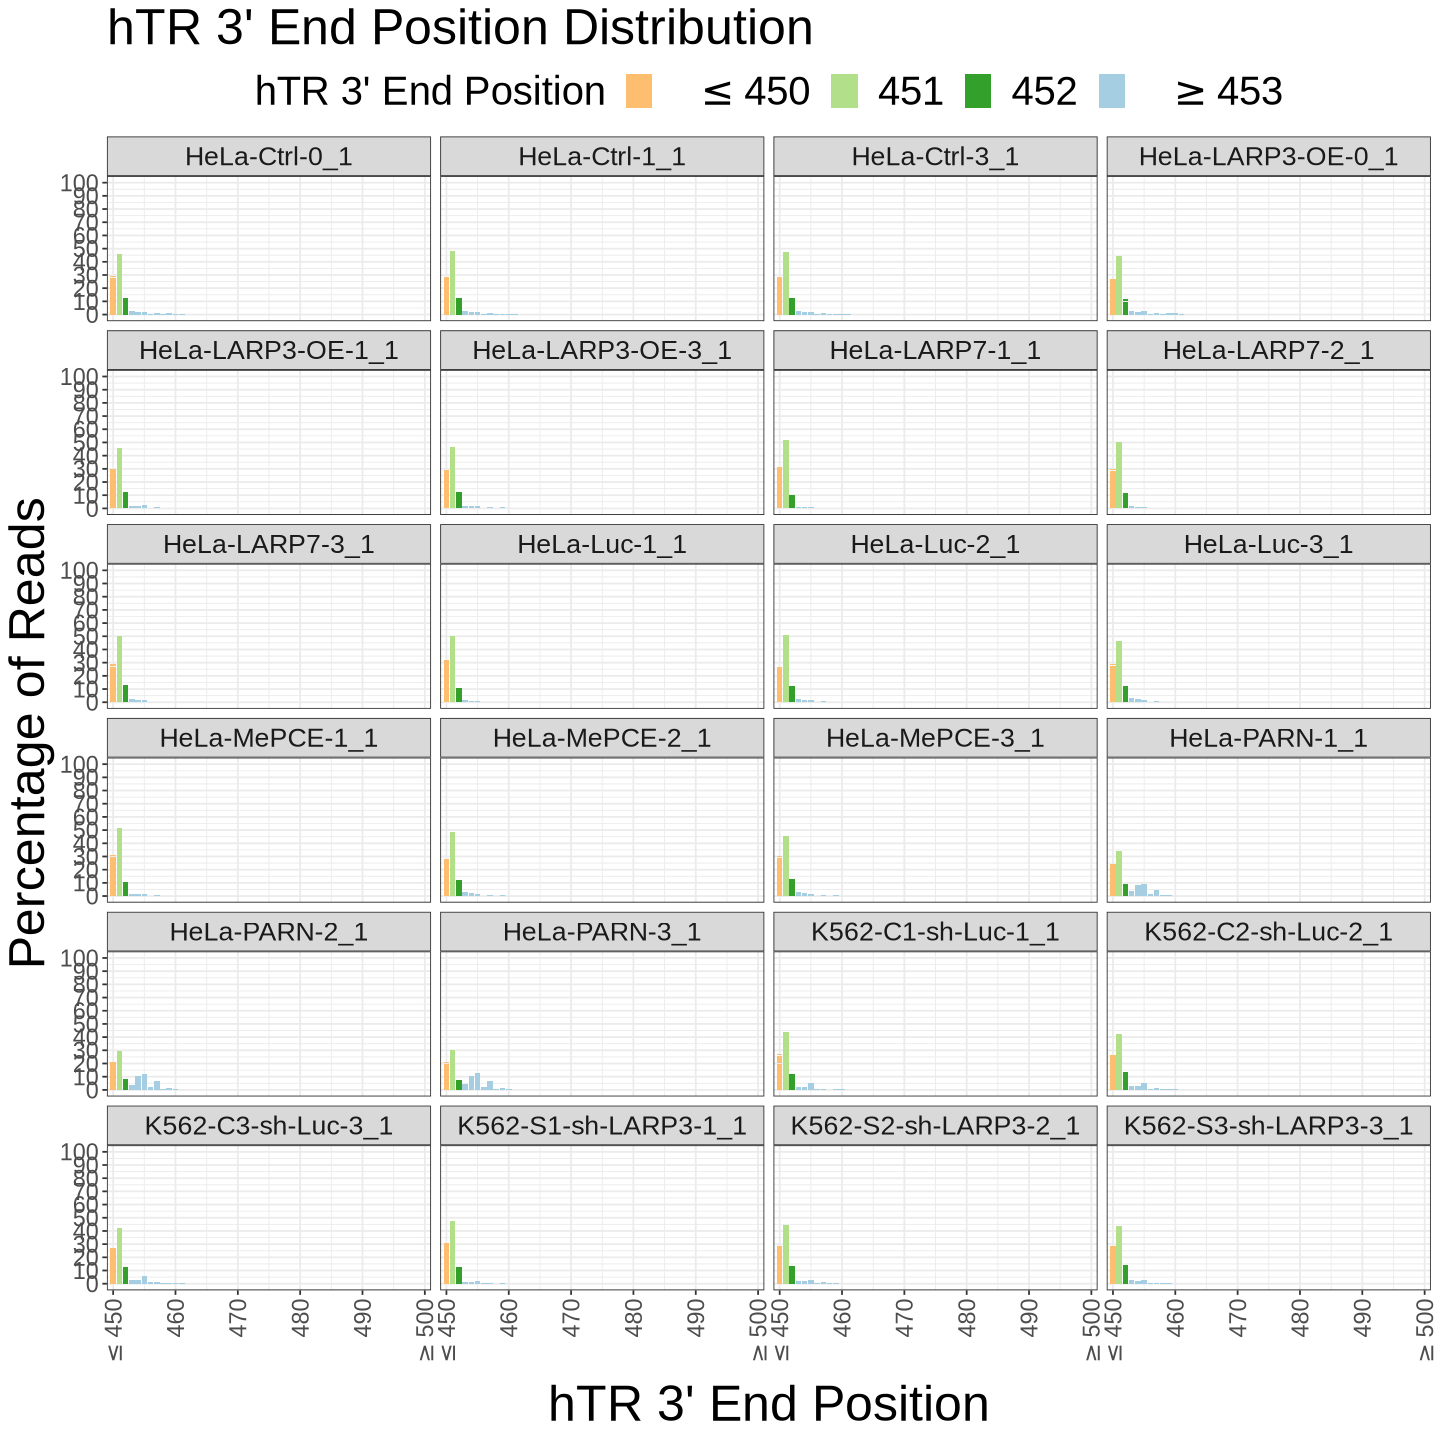

In [2]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "/mnt/NFS/pisces/gcobs/project//HL23607/processed_data/all_samples.tsv",
                   header = FALSE, 
                   sep = "\t")
# name cols
colnames(data) <- c('ntna', 'hTR_end', 'reads', 
                    'perc_reads', 'tota_reads', 'sample')

################## bin data in groups <= 450, 451, 452 & >=453 ##################
sub_450 <- subset(data, data$hTR_end <= 450.0)
sub_450$bin <- rep("<=450", nrow(sub_450))
sub_450$hTR_end <- rep(450.0, nrow(sub_450))

sub_451 <- subset(data, data$hTR_end == 451.0)
sub_451$bin <- rep("451", nrow(sub_451))
sub_452 <- subset(data, data$hTR_end == 452.0)
sub_452$bin <- rep("452", nrow(sub_452))

sub_453 <- subset(data, data$hTR_end >= 453.0 & data$hTR_end < 500.0)
sub_453$bin <- rep(">=453", nrow(sub_453))

sub_500 <- subset(data, data$hTR_end >= 500.0)
sub_500$bin <- rep(">=453", nrow(sub_500))
sub_500$hTR_end <- rep(500.0, nrow(sub_500))

bin_data <- rbind(sub_450, sub_451, sub_452, sub_453, sub_500)
#####################################################################################

# plot dataframe
g <- ggplot(bin_data, 
            aes(x = hTR_end, 
                y = perc_reads, 
                fill = as.factor(bin))) + 
            geom_bar(stat = 'identity') +
            theme_bw() +
            scale_y_continuous(expand = waiver(), 
                               limits = c(0, 100), 
                               breaks = seq(0,100,10)) +
            scale_x_continuous(expand = c(0,0), 
                               limits = c(449,501), 
                               breaks = seq(450, 500, 10), 
                               labels = c(expression(phantom(x)<= 450), 
                                          "460", "470", "480", "490", 
                                          expression(phantom(x)>= 500))) +
            ggtitle("hTR 3' End Position Distribution") +
            xlab("hTR 3' End Position") + ylab("Percentage of Reads") +
            theme(plot.title   = element_text(size=30),
                  axis.text.x  = element_text(size=14, 
                                              angle = 90, 
                                              vjust = 0.5, 
                                              hjust = 1),
                  axis.text.y  = element_text(size=14),
                  axis.title.x = element_text(size=30),
                  axis.title.y = element_text(size=30),
                  strip.text   = element_text(size=16),
                  legend.text  = element_text(size=24),
                  legend.title = element_text(size=24),
                   legend.key  = element_blank(),
                 legend.position='top') +
            scale_fill_manual(name="hTR 3' End Position",
                            values=c("<=450" = "#FDBF6F", 
                                     "451"   = "#B2DF8A",
                                     "452"   = "#33A02C", 
                                     ">=453" = "#A6CEE3"),
                            labels=c(expression(phantom(x)<= 450),  
                                     "451", "452", 
                                     expression(phantom(x)>= 453)),
                             breaks=c("<=450", "451", "452", ">=453")) +
            facet_wrap(~sample, ncol = 4)

# save figure
#ggsave(g, 
#       file="./fig/all_samples_facet_hTR_end_dist.pdf",
#       width = 12, height = 12)

g

In [3]:
ggsave("/mnt/NFS/pisces/gcobs/project//HL23607/fig/hTR_ending_positions.png", g, width = 10, height = 10, dpi = 300)

>**In the figure above, we compare the hTR ending position in knock out samples to the control. The mature form of hTR ends at position 451, and this dominant population of hTR in the control sample. If there is an increase in the precursor population of hTR (>= 453) or premature form (<= 450) we can determine where in the RNA processing and degradation mechanism these knock out samples fit in.** 

## Binning hTR ends into categories

In [3]:
def bin_hTR_forms(samp, min_bin, max_bin, out_type):
    """ this function takes the output files in the ntna_dict_BCFILER.
    It bins this data into categories with user supplied min & max bin. 
    User defines out_type to decide if normalized percent reads (out_type='perc reads')
    or read count (out_type='num reads') are to be used."""
    
    bins = Counter()
    
    with open(samp, 'r') as fh:
      
        for line in fh:
            line = line.strip('\n')
            ntna = line.split("\t")[0]
            #print(type(line.split("\t")[1]))
            hTR_end = int(float(line.split("\t")[1]))
            reads = int(float(line.split("\t")[2]))
            perc = float(line.split("\t")[3])
            total_reads = line.split("\t")[4]
            
            if out_type == 'perc reads':
                out_count = perc
            elif out_type == 'num reads':
                out_count = reads
        
        
            if hTR_end <= min_bin: 
                if len(ntna) == 0:
                    bins['<='+str(min_bin)] += out_count
                else:
                    if ntna == 'A':
                        bins['<='+str(min_bin)+'_A'] += out_count
                    elif ntna == 'T':
                        key = '<='+str(min_bin)+'_T'
                        bins[key] += out_count
                    elif ntna == 'C':
                        key = '<='+str(min_bin)+'_C'
                        bins[key] += out_count
                    elif ntna == 'G':
                        key = '<='+str(min_bin)+'_G'
                        bins[key] += out_count
                    else:
                        non_A = sum(y != 'A' for y in ntna)
                        if non_A/float(len(ntna)) <= 0.1:
                            bins['<='+str(min_bin)+'_An'] += out_count
                        else:
                            bins['<='+str(min_bin)+'_other'] += out_count

            elif hTR_end in range(min_bin+1, max_bin):
                for i in range(min_bin+1, max_bin):
                    if hTR_end == i:
                        if len(ntna) == 0:
                            bins[str(i)] += out_count
                        else:
                            if ntna == 'A':
                                key = str(i)+'_A'
                                bins[key] += out_count
                            elif ntna == 'T':
                                key = str(i)+'_T'
                                bins[key] += out_count
                            elif ntna == 'C':
                                key = str(i)+'_C'
                                bins[key] += out_count
                            elif ntna == 'G':
                                key = str(i)+'_G'
                                bins[key] += out_count
                            
                            else:
                                non_A = sum(y != 'A' for y in ntna)
                                if non_A/float(len(ntna)) <= 0.1:
                                    key = str(i)+'_An'
                                    bins[key] += out_count
                                else:
                                    key = str(i)+'_other'
                                    bins[key] += out_count
            elif hTR_end >= max_bin: 
                if len(ntna) == 0:
                    bins['>='+str(max_bin)] += out_count
                else:
                    if ntna == 'A':
                        bins['>='+str(max_bin)+'_A'] += out_count
                    elif ntna == 'T':
                        key = '>='+str(max_bin)+'_T'
                        bins[key] += out_count
                    elif ntna == 'C':
                        key = '>='+str(max_bin)+'_C'
                        bins[key] += out_count
                    elif ntna == 'G':
                        key = '>='+str(max_bin)+'_G'
                        bins[key] += out_count
                    else:
                        non_A = sum(y != 'A' for y in ntna)
                        if non_A/float(len(ntna)) <= 0.1:
                            bins['>='+str(max_bin)+'_An'] += out_count
                        else:
                            bins['>='+str(max_bin)+'_other'] += out_count


    
    return bins

### bin into <= 386, 387, ... , 451, ..., 460, >=461

> <= 386, <=386+An, <= 386 + other

> ...

> 451, 451 + An, 451 + other

> ...

> 458, 458 + An, 458 + other

> 459, 459 + An, 459 + other

> \>= 460, >= 460 + An, >= 460 + other

    &
- hTRend_ + T
- hTRend_ + C
- hTRend_ + G

In [7]:
#%%bash

# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets
!mkdir -p ./spreadsheets

In [8]:
# test one file
# bin_hTR_forms("/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv",
#              min_bin=386, max_bin=461, out_type = 'perc reads')
bin_hTR_forms("./processed_data/ntna_dict_BCFILTER/HeLa-Ctrl-0_1.tsv",
             min_bin=386, max_bin=461, out_type = 'perc reads')

Counter({'451': 37.023636562727994,
         '452': 8.496056097766653,
         '450_A': 4.065611295406479,
         '451_other': 3.62870051557485,
         '450': 3.5716008832192947,
         '451_T': 3.4026514199600344,
         '449_other': 2.7435513286257933,
         '448_other': 2.633085985501476,
         '449': 2.2688817911747714,
         '451_C': 2.1675624582293747,
         '452_An': 1.7521741702408122,
         '452_A': 1.7009061682286906,
         '453_An': 1.609110433038409,
         '454_An': 1.2798121124220851,
         '447': 1.2407947295487032,
         '455_An': 1.0619440809581324,
         '450_T': 0.9928455545146259,
         '448': 0.8747445515161609,
         '452_other': 0.7510216890499197,
         '388': 0.7309256391613697,
         '447_other': 0.7078508428384028,
         '453': 0.6800352247254414,
         '446': 0.6008676962500938,
         '448_An': 0.5598365129703431,
         '450_other': 0.5185536046397973,
         '449_A': 0.5081489692068941,
       

In [11]:
df = pd.DataFrame()

# path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
# path = "/mnt/NFS/pisces/gcobs/test/race/processed_data/ntna_dict_BCFILTER/"
path = work_dir + "processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=386, max_bin=461, out_type = 'perc reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print(sample)
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    #df = df.append(temp_df)
    df = pd.concat([df, temp_df])
    
    
#df = df.transpose()
#df = df.sort()
df

,451,452,454_other,447_other,449_other,455_A,446,452_A,451_other,391_A,...,431_An,428_G,426_G,421_G,397_G,427_An,447_An,424_G,421_T,445_An
HeLa-Ctrl-1_1,39.910871,8.227932,0.350736,0.661056,2.647406,0.336235,0.643795,1.639403,3.199331,0.096268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Luc-2_1,41.684806,7.797882,0.346434,0.580365,2.628819,0.342720,0.511619,1.506104,2.550568,0.097403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-3_1,26.467323,4.213121,2.041450,0.367661,1.478370,1.003350,0.613840,0.830060,1.374577,0.054046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP7-3_1,41.242702,8.329792,0.245816,0.670267,2.951749,0.296994,0.930032,1.747443,3.136496,0.092887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-1_1,28.655349,5.726020,1.951999,0.487049,1.844630,0.897612,0.550435,1.062803,2.564410,0.087895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP3-OE-0_1,37.758468,7.741020,0.404844,0.577369,2.283831,0.618113,0.510285,1.493019,2.896390,0.114424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Ctrl-0_1,37.023637,8.496056,0.414214,0.707851,2.743551,0.343311,0.600868,1.700906,3.628701,0.068050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-2_1,38.618624,7.856310,0.405746,0.596965,2.739975,0.381784,0.816721,1.651000,3.037195,0.086351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-1_1,41.510977,7.591368,0.252972,0.612485,2.989002,0.283695,0.822942,1.100741,2.387112,0.120222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K562-C2-sh-Luc-2_1,34.686696,8.758481,0.558949,0.638980,2.551265,0.890020,0.612316,1.558370,3.001489,0.062999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.to_csv("./out55.csv")

In [13]:
# save as excel file 
# writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets/testcase_hTR_3prime_end_summary.xlsx')
writer = pd.ExcelWriter('./spreadsheets/testcase_hTR_3prime_end_summary.xlsx')
df.to_excel(writer,'Sheet1')
# writer.save()
writer.close()

In [4]:
df = pd.DataFrame()

# path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
# path = "/mnt/NFS/pisces/gcobs/test/race/processed_data/ntna_dict_BCFILTER/"
path = work_dir + "processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=386, max_bin=461, out_type = 'num reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print(sample)
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    #df = df.append(temp_df)
    df = pd.concat([df, temp_df])
    
    
#df = df.transpose()
#df = df.sort()
df

,451,452,454_other,447_other,449_other,455_A,446,452_A,451_other,391_A,...,431_An,428_G,426_G,421_G,397_G,427_An,447_An,424_G,421_T,445_An
HeLa-Ctrl-1_1,853211,175896,7498,14132,56596,7188,13763,35047,68395,2058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Luc-2_1,864056,161637,7181,12030,54491,7104,10605,31219,52869,2019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-3_1,757102,120517,58396,10517,42289,28701,17559,23744,39320,1546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP7-3_1,884027,178547,5269,14367,63270,6366,19935,37456,67230,1991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-1_1,813742,162605,55432,13831,52383,25490,15631,30181,72823,2496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP3-OE-0_1,870179,178399,9330,13306,52633,14245,11760,34408,66750,2637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Ctrl-0_1,882478,202508,9873,16872,65394,8183,14322,40542,86492,1622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-2_1,886404,180324,9313,13702,62890,8763,18746,37895,69712,1982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-1_1,901200,164808,5492,13297,64891,6159,17866,23897,51824,2610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K562-C2-sh-Luc-2_1,871591,220079,14045,16056,64107,22364,15386,39158,75420,1583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.to_csv('./58.csv')

In [ ]:
# save as excel file 
# writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets/testcase_hTR_3prime_end_summary.xlsx')
writer = pd.ExcelWriter('./spreadsheets/testcase_number_read_counts_hTR_3prime_end_summary.xlsx')
df.to_excel(writer,'Sheet1')
# writer.save()
writer.close()

### bin into <= 442, 443, ... , 451, ..., 499, >=500

> <= 442, <=442+An, <= 442 + other

> 443, 443 + An, 443 + other

> ...

> 451, 451 + An, 451 + other

> ...

> 458, 458 + An, 458 + other

> 459, 459 + An, 459 + other

> ...
> \>= 500, >= 500 + An, >= 500 + other

    & 
- hTRend_ + T
- hTRend_ + C
- hTRend_ + G

In [14]:
#%%bash

# mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA
!mkdir -p ./spreadsheets_leq442gt500_polyA

In [15]:
# test one file
# bin_hTR_forms("/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv",
#              min_bin=442, max_bin=500, out_type = 'perc reads')
bin_hTR_forms("./processed_data/ntna_dict_BCFILTER/HeLa-Ctrl-0_1.tsv",
             min_bin=442, max_bin=500, out_type = 'perc reads')

Counter({'451': 37.023636562727994,
         '452': 8.496056097766653,
         '450_A': 4.065611295406479,
         '451_other': 3.62870051557485,
         '450': 3.5716008832192947,
         '451_T': 3.4026514199600344,
         '<=442': 3.07884909628609,
         '449_other': 2.7435513286257933,
         '448_other': 2.633085985501476,
         '449': 2.2688817911747714,
         '451_C': 2.1675624582293747,
         '452_An': 1.7521741702408122,
         '452_A': 1.7009061682286906,
         '453_An': 1.609110433038409,
         '454_An': 1.2798121124220851,
         '447': 1.2407947295487032,
         '<=442_other': 1.0671883528496944,
         '455_An': 1.0619440809581324,
         '450_T': 0.9928455545146259,
         '448': 0.8747445515161609,
         '452_other': 0.7510216890499197,
         '447_other': 0.7078508428384028,
         '453': 0.6800352247254414,
         '446': 0.6008676962500938,
         '448_An': 0.5598365129703431,
         '450_other': 0.5185536046397973,
 

In [16]:
df = pd.DataFrame()

# path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
path = work_dir + "processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=442, max_bin=500, out_type = 'perc reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    #df = df.append(temp_df)
    df = pd.concat([df, temp_df])
    
    
#df = df.transpose()
#df = df.sort()
df

,451,452,454_other,447_other,449_other,455_A,446,452_A,451_other,<=442_A,...,470_T,480_T,474_An,447_An,487_other,477_G,484_G,486_T,466_C,445_An
HeLa-Ctrl-1_1,39.910871,8.227932,0.350736,0.661056,2.647406,0.336235,0.643795,1.639403,3.199331,0.544300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Luc-2_1,41.684806,7.797882,0.346434,0.580365,2.628819,0.342720,0.511619,1.506104,2.550568,0.445140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-3_1,26.467323,4.213121,2.041450,0.367661,1.478370,1.003350,0.613840,0.830060,1.374577,0.372905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP7-3_1,41.242702,8.329792,0.245816,0.670267,2.951749,0.296994,0.930032,1.747443,3.136496,0.487293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-1_1,28.655349,5.726020,1.951999,0.487049,1.844630,0.897612,0.550435,1.062803,2.564410,0.459547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP3-OE-0_1,37.758468,7.741020,0.404844,0.577369,2.283831,0.618113,0.510285,1.493019,2.896390,0.552202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Ctrl-0_1,37.023637,8.496056,0.414214,0.707851,2.743551,0.343311,0.600868,1.700906,3.628701,0.476432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-2_1,38.618624,7.856310,0.405746,0.596965,2.739975,0.381784,0.816721,1.651000,3.037195,0.488874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-1_1,41.510977,7.591368,0.252972,0.612485,2.989002,0.283695,0.822942,1.100741,2.387112,0.488486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K562-C2-sh-Luc-2_1,34.686696,8.758481,0.558949,0.638980,2.551265,0.890020,0.612316,1.558370,3.001489,0.540284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# save as excel sheet
# writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA/testcase_hTR_3prime_end_polyA_summary.xlsx')
writer = pd.ExcelWriter('./spreadsheets_leq442gt500_polyA/testcase_hTR_3prime_end_polyA_summary.xlsx')
df.to_excel(writer,'Sheet1')
# writer.save()
writer.close()

In [18]:
# same for number of reads

df = pd.DataFrame()

# path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
path = work_dir + "processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=442, max_bin=500, out_type = 'num reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    # df = df.append(temp_df)
    df = pd.concat([df, temp_df])
    
    
#df = df.transpose()
#df = df.sort()

df

,451,452,454_other,447_other,449_other,455_A,446,452_A,451_other,<=442_A,...,470_T,480_T,474_An,447_An,487_other,477_G,484_G,486_T,466_C,445_An
HeLa-Ctrl-1_1,853211,175896,7498,14132,56596,7188,13763,35047,68395,11636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Luc-2_1,864056,161637,7181,12030,54491,7104,10605,31219,52869,9227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-3_1,757102,120517,58396,10517,42289,28701,17559,23744,39320,10667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP7-3_1,884027,178547,5269,14367,63270,6366,19935,37456,67230,10445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-PARN-1_1,813742,162605,55432,13831,52383,25490,15631,30181,72823,13050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-LARP3-OE-0_1,870179,178399,9330,13306,52633,14245,11760,34408,66750,12726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-Ctrl-0_1,882478,202508,9873,16872,65394,8183,14322,40542,86492,11356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-2_1,886404,180324,9313,13702,62890,8763,18746,37895,69712,11221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HeLa-MePCE-1_1,901200,164808,5492,13297,64891,6159,17866,23897,51824,10605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K562-C2-sh-Luc-2_1,871591,220079,14045,16056,64107,22364,15386,39158,75420,13576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#df.to_csv('./out58.csv')
df = pd.DataFrame()

path = work_dir + "processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=442, max_bin=500, out_type = 'num reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    # df = df.append(temp_df)
    df = pd.concat([df, temp_df])
    
    
#df = df.transpose()
#df = df.sort()

# df
df.to_csv('./out63.csv')

In [20]:
# save num reads as excel file
# writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA/testcase_read_counts_hTR_3prime_end_polyA_summary.xlsx')
writer = pd.ExcelWriter('./spreadsheets_leq442gt500_polyA/testcase_read_counts_hTR_3prime_end_polyA_summary.xlsx')
df.to_excel(writer,'Sheet1')
# writer.save()
writer.close()

## Identify & Plot distribution of polyA tails

### Identify polyA tails

In [21]:
#%%bash
# prepare output directories
!mkdir -p ./spreadsheets/A_dist_df_10percNonA/
!mkdir -p ./processed_data/A_dist_df_10percNonA/
!mkdir -p ./fig/A_dist_df_10percNonA

In [22]:
def get_A_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a polyA tail. It returns a dictionary where 
    the key is a tuple of:
        (polyA ntna sequene, lenght of the polyA sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyA definitions to choose from are:
        (1) pure polyA (no other nt present)
        (2) polyA sequence allowing 10% non-As (to accound for sequencing error or a
    sloppy poly-A polymerase adding non-As). This threshold can easily be changed to allow 
    any percent deviation from pure polyA. This threshold only takes effect when the polyA sequence
    is at least 10nt. So an ntna sequence with 9 As and 1 non-A will get counted.
    """
    # key = (polyA ntna seq, len, end pos), val = reads
    dist_A_dict = Counter() # initialize counter dict

    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    with open(samp, 'r') as fh:

        not_A = ['C','G','T'] # this is for computing the pure A

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all A's in ntna seq
                    pure_A = map(lambda x: x in ntna, not_A) # checks ntna sequence if all As, if so returns True
                    if True in pure_A: # if there is a pure polyA sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_A_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-A in ntna seq
                    non_A = sum(y != 'A' for y in ntna) # count how many times a non-A seq is found in the ntna
                    if float(non_A)/float(len(ntna)) <= 0.1: # non-A seq divided by the total length of the seq 
                                                             # give the fraction of non-A's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_A_dict[key] += reads
            elif len(ntna) == 0 and end_pos == 452:
                dist_A_dict[('A', 1, '451', total_reads, sample)] += reads
            
    return dist_A_dict

In [23]:
def make_A_dist_df(A_dist_dict):
    """ this function converts your A_dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_A', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in A_dist_dict.items(): # loop through dict
        h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of polyA seq, hTR ending coordinate
                                                             # and compute normalized percent of reads
        # add to dataframe
        # df = df.append(pd.Series(h, index = ['len_A', 'hTR_end', 'perc_reads', 'sample']), 
        #                ignore_index=True)
        
        # print(pd.Series(h, index = ['Len_A', 'hTR_end', 'perc_reads', 'sample']).to_frame().T)
        df = pd.concat([df, pd.Series(h, index = ['len_A', 'hTR_end', 'perc_reads', 'sample']).to_frame().T], ignore_index=True)
    
    return df

In [46]:
path = "./processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize summary dataframe

for sample in os.listdir(path): # for each sample
    A_dist = get_A_dist(path + sample, 'allow_10%_non') # call the get_A_dist function with polyA threshold allowing 10% nonA
    df_A = make_A_dist_df(A_dist) # conver get_A_dist dict to dataframe
    sample = re.split('_1', re.split(r'[.]', sample)[0])[0] # grab the sample name
    out_file = "./processed_data/A_dist_df_10percNonA/" + sample + ".csv" # outfile named by sample
    df_A.to_csv(out_file, index = False) # save dataframe as csv
    
    # save as excel spreadsheet, each sample will be a differnt tab
    writer = pd.ExcelWriter('./spreadsheets/A_dist_df_10percNonA/' + sample + '.xlsx')
    df_A.to_excel(writer, sample)
    # writer.save()
    writer.close()
    
    # df_summary = df_summary.append(df_A)
    df_summary = pd.concat([df_summary, df_A])

df_summary

out_file = "./processed_data/A_dist_df_10percNonA/sample_summary_Adist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/A_dist_df_10percNonA/sample_summary_Adist.xlsx')
df_summary.to_excel(writer)
# writer.save()
writer.close()

In [25]:
############## testing get_A_dist function #################

# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
# sample = "HeLa_totalRNA_1.tsv"
path = "./processed_data/ntna_dict_BCFILTER/"
sample = "HeLa-Ctrl-0_1.tsv"
A_dist = get_A_dist(path + sample, 'allow_10%_non')
A_dist
#make_A_dist_df(A_dist)

Counter({('A', 1, '451', 2383553, 'HeLa-Ctrl-0'): 202508,
         ('A', 1, '<=450', 2383553, 'HeLa-Ctrl-0'): 132415,
         ('A', 1, '452', 2383553, 'HeLa-Ctrl-0'): 40542,
         ('A', 1, '>=454', 2383553, 'HeLa-Ctrl-0'): 29205,
         ('AA', 2, '<=450', 2383553, 'HeLa-Ctrl-0'): 23784,
         ('AA', 2, '>=454', 2383553, 'HeLa-Ctrl-0'): 20836,
         ('AAA', 3, '>=454', 2383553, 'HeLa-Ctrl-0'): 19724,
         ('AAAA', 4, '>=454', 2383553, 'HeLa-Ctrl-0'): 18617,
         ('AAAAA', 5, '>=454', 2383553, 'HeLa-Ctrl-0'): 16242,
         ('AA', 2, '452', 2383553, 'HeLa-Ctrl-0'): 10880,
         ('AAAA', 4, '453', 2383553, 'HeLa-Ctrl-0'): 8172,
         ('AAA', 3, '452', 2383553, 'HeLa-Ctrl-0'): 7275,
         ('AAAAA', 5, '453', 2383553, 'HeLa-Ctrl-0'): 7097,
         ('AAAA', 4, '452', 2383553, 'HeLa-Ctrl-0'): 6821,
         ('AAA', 3, '453', 2383553, 'HeLa-Ctrl-0'): 6561,
         ('AA', 2, '453', 2383553, 'HeLa-Ctrl-0'): 6093,
         ('AAA', 3, '<=450', 2383553, 'HeLa-Ctrl-0'

### Plot polyA tail distribution

In [45]:
#%%bash
# concatonate each Adist per sample into one file
# for i in ./A_dist_df_10percNonA/*.csv; do cat $i | grep -v "len_A" | sed "s/$/,$(basename $i .csv)/" >> ./A_dist_df_10percNonA/all_samples.csv; done
!for i in ./processed_data/A_dist_df_10percNonA/*.csv; do cat $i | grep -v "len_A" | sed "s/$/,$(basename $i .csv)/" >> ./processed_data/A_dist_df_10percNonA/all_samples.csv; done

In [4]:
## start R kernel
library(ggplot2)
library(RColorBrewer)

Warning message:
“Removed 66 rows containing missing values (`geom_bar()`).”


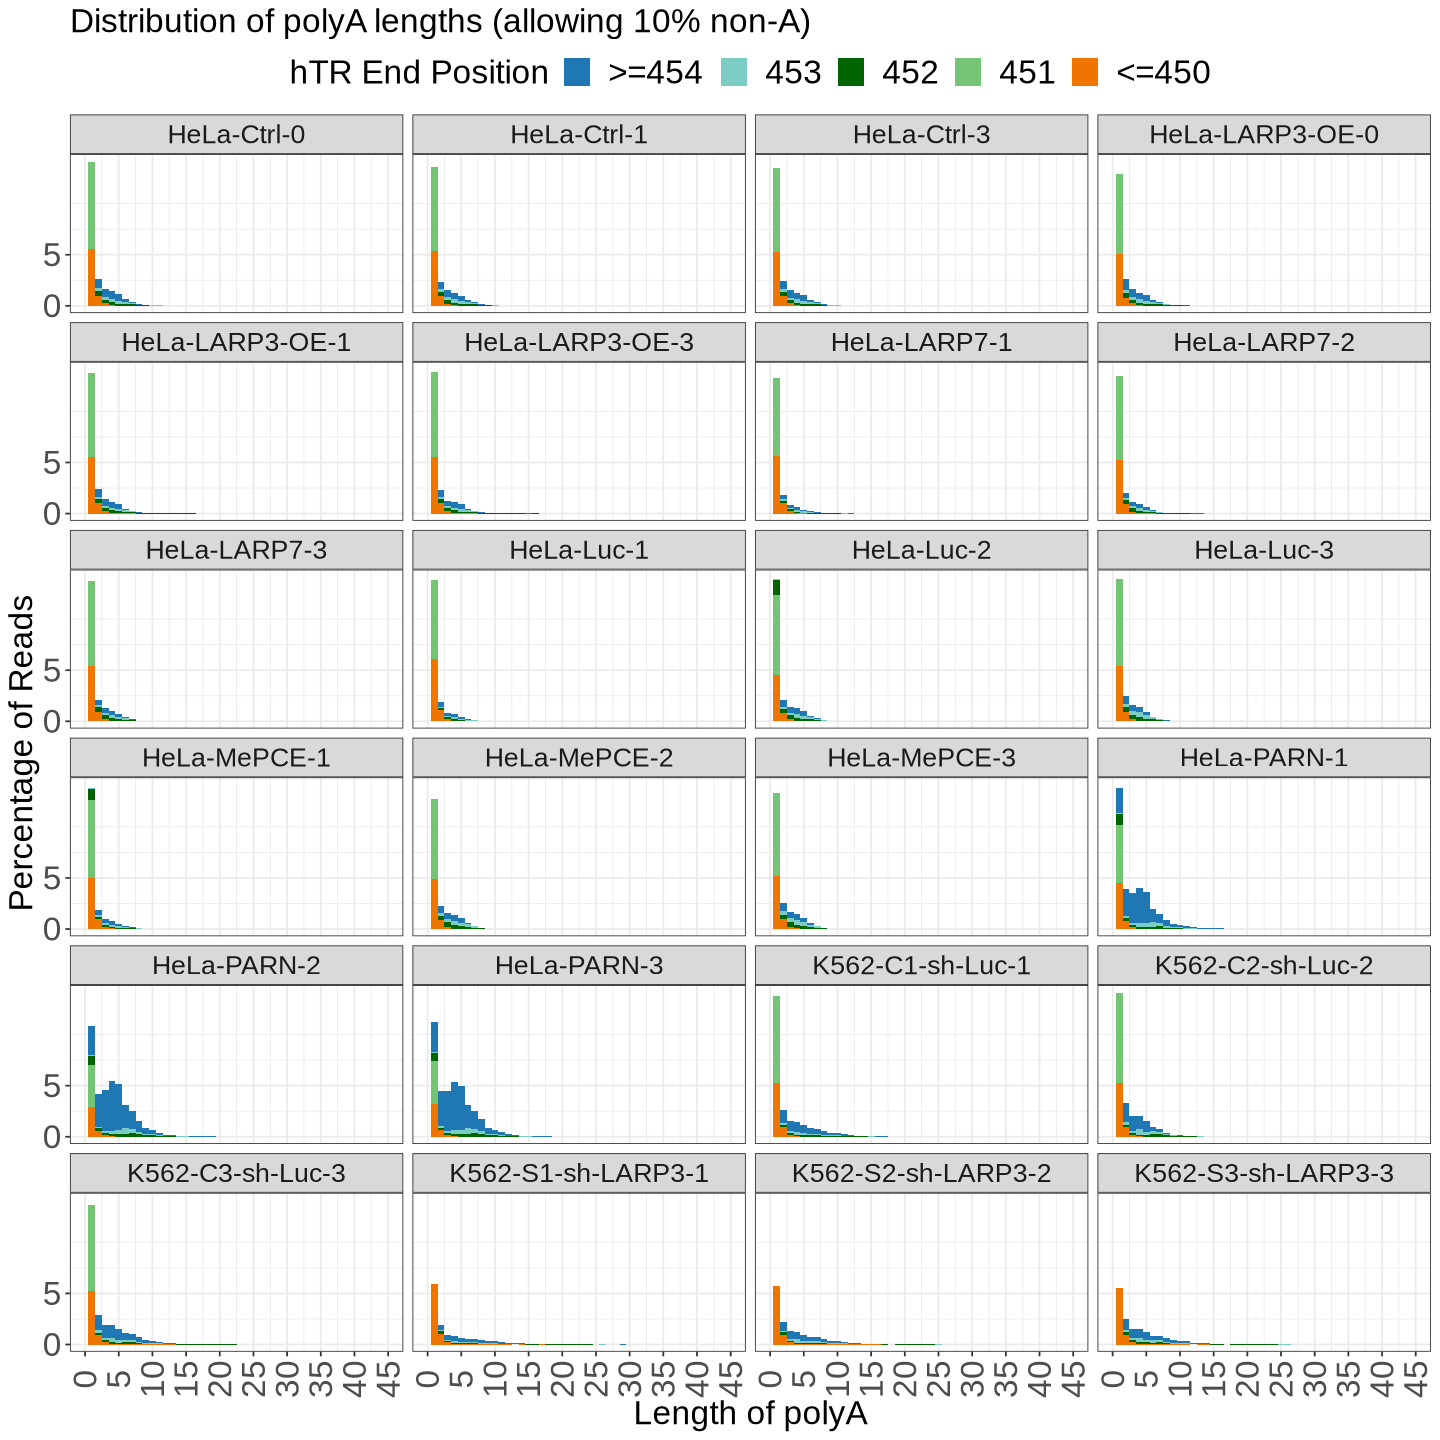

In [5]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "/mnt/NFS/pisces/gcobs/project/HL23607/processed_data/A_dist_df_10percNonA/all_samples.csv",
                   header = FALSE, 
                   sep = ",")
# name cols
colnames(data) <- c('len_A', 'hTR_end', 'perc_reads', 'sample')

###################### bin data in groups <= 450, 451, 452, 453 & >=454 ######################
data_450 <- subset(data, data$hTR_end == "<=450")
data_451 <- subset(data, hTR_end == "451")
data_452 <- subset(data, hTR_end == "452")
data_453 <- subset(data, data$hTR_end == "453")
data_454 <- subset(data, data$hTR_end == ">=454")
data_bins <- rbind(data_450, data_451, data_452, data_453, data_454)
data_bins$hTR_end <- factor(data_bins$hTR_end, 
                            levels = rev(c("<=450", '451', '452', '453', ">=454")))
################################################################################################

# plot dataframe
g <- ggplot(data_bins, 
            aes(x    = len_A, 
                y    = perc_reads, 
                fill = hTR_end)) + 

        geom_bar(width    = 1, 
                 stat     = 'identity', 
                 alpha    = 1, 
                 position = 'stack') +
        
        scale_y_continuous(limits = c(0, max(data_bins$perc_reads)+5), 
                           breaks = seq(0, max(data_bins$perc_reads), 5))+
        scale_x_continuous(limits = c(0,max(data_bins$len_A)), 
                           breaks = seq(0, max(data_bins$len_A), 5))+

        ggtitle("Distribution of polyA lengths (allowing 10% non-A)")+
        xlab("Length of polyA") + ylab("Percentage of Reads") +
        scale_fill_manual(name = "hTR End Position",
                          values = rev(c("darkorange2", "#74c476", 
                                         "DarkGreen", "#7BCCC4", "#1F78B4")))+
        theme_bw()+
        theme(plot.title   = element_text(size = 20),
              axis.text.x  = element_text(size = 20, 
                                          angle = 90, 
                                          vjust = 0.5),
              axis.text.y  = element_text(size = 20),
              axis.title.x = element_text(size = 20),
              axis.title.y = element_text(size = 20),
              strip.text   = element_text(size = 16),
              legend.text  = element_text(size = 20),
              legend.title = element_text(size = 20),
              legend.key   = element_blank(),
              legend.position = 'top') +
            facet_wrap(~sample, ncol = 4)

# save fig
#ggsave(file="./fig/A_dist_df_10percNonA/all_samples_polyA_len_stack.pdf", 
#       g, width = 14, height = 14)
g

In [6]:
ggsave("/mnt//NFS/pisces/gcobs/project//HL23607/fig/A_dist_df_10percNonA/distribution_of_polyA_tails.png", g, width = 10, height = 10, dpi = 300)

Warning message:
“Removed 66 rows containing missing values (`geom_bar()`).”


## PolyT distribution

In [27]:
#%%bash
# prepare output directories
!mkdir -p ./spreadsheets/T_dist_df_10percNonT/
!mkdir -p ./processed_data/T_dist_df_10percNonT/

In [28]:
def get_T_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a polyT tail. It returns a dictionary where 
    the key is a tuple of:
        (polyT ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyT definitions to choose from are:
        (1) pure polyT (no other nt present)
        (2) polyT sequence allowing 10% non-Ts This threshold can easily be changed to allow 
    any percent deviation from pure polyT. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_T_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_T = ['C','G','A'] # this is for computing the pure T

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all T's in ntna seq
                    pure = map(lambda x: x in ntna, not_T) # checks ntna sequence if all Ts, if so returns True
                    if True in pure: # if there is a pure polyT sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_T_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-T in ntna seq
                    non_T = sum(y != 'T' for y in ntna) # count how many times a non-T seq is found in the ntna
                    if float(non_T)/float(len(ntna)) <= 0.1: # non-T seq divided by the total length of the seq 
                                                             # give the fraction of non-T's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_T_dict[key] += reads
    return dist_T_dict

In [29]:
def make_T_dist_df(T_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in T_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            # df = df.append(pd.Series(h, index = ['len_T', 'hTR_end', 'perc_reads', 'sample']), 
            #                ignore_index=True)
            df = pd.concat([df, pd.Series(h, index = ['len_T', 'hTR_end', 'perc_reads', 'sample']).to_frame().T], 
                       ignore_index=True)
    
    return df

In [30]:
# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
path = "./processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    T_dist = get_T_dist(path + sample, 'allow_10%_non') # call the get_T_dist function with polyT threshold allowing 10% nonT
    df_T = make_T_dist_df(T_dist) # convert get_T_dist dict to dataframe
    # df_summary = df_summary.append(df_T)
    df_summary = pd.concat([df_summary, df_T])
df_summary

out_file = "./processed_data/T_dist_df_10percNonT/sample_summary_Tdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/T_dist_df_10percNonT/sample_summary_Tdist.xlsx')
df_summary.to_excel(writer)
# writer.save()
writer.close()

In [32]:
############## testing get_T_dist function #################

# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
# sample = "HeLa_totalRNA_1.tsv"
path = "./processed_data/ntna_dict_BCFILTER/"
sample = "HeLa-Ctrl-0_1.tsv"
T_dist = get_T_dist(path + sample, 'allow_10%_non')
print(T_dist)
df_T = make_T_dist_df(T_dist) # convert get_T_dist dict to dataframe
print(df_T)

Counter({('T', 1, '451', 2383553, 'HeLa-Ctrl-0'): 81104, ('T', 1, '<=450', 2383553, 'HeLa-Ctrl-0'): 30628, ('TT', 2, '451', 2383553, 'HeLa-Ctrl-0'): 7799, ('T', 1, '452', 2383553, 'HeLa-Ctrl-0'): 5356, ('TT', 2, '<=450', 2383553, 'HeLa-Ctrl-0'): 4636, ('TTT', 3, '<=450', 2383553, 'HeLa-Ctrl-0'): 1381, ('T', 1, '>=454', 2383553, 'HeLa-Ctrl-0'): 1059, ('TTT', 3, '451', 2383553, 'HeLa-Ctrl-0'): 588, ('TTTT', 4, '<=450', 2383553, 'HeLa-Ctrl-0'): 287, ('TT', 2, '452', 2383553, 'HeLa-Ctrl-0'): 251, ('TT', 2, '>=454', 2383553, 'HeLa-Ctrl-0'): 210, ('TTTTT', 5, '<=450', 2383553, 'HeLa-Ctrl-0'): 36, ('TTTT', 4, '>=454', 2383553, 'HeLa-Ctrl-0'): 29, ('TTTTTTT', 7, '<=450', 2383553, 'HeLa-Ctrl-0'): 22, ('TTT', 3, '>=454', 2383553, 'HeLa-Ctrl-0'): 20, ('TTTTTTTTT', 9, '<=450', 2383553, 'HeLa-Ctrl-0'): 12, ('TTTTTTTTTT', 10, '<=450', 2383553, 'HeLa-Ctrl-0'): 10, ('TTTTT', 5, '>=454', 2383553, 'HeLa-Ctrl-0'): 9, ('ATTTTTTTTT', 10, '>=454', 2383553, 'HeLa-Ctrl-0'): 8, ('TTTTTTTTTTA', 11, '<=450', 238

## PolyG distribution

In [33]:
#%%bash
# prepare output directories
!mkdir -p ./spreadsheets/G_dist_df_10percNonG/
!mkdir -p ./processed_data/G_dist_df_10percNonG/

In [34]:
def get_G_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a poly tail. It returns a dictionary where 
    the key is a tuple of:
        (polyN ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyN definitions to choose from are:
        (1) pure polyN (no other nt present)
        (2) polyN sequence allowing 10% non-Gs This threshold can easily be changed to allow 
    any percent deviation from pure polyG. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_G_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_G = ['C','T','A'] # this is for computing the pure G

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all G's in ntna seq
                    pure = map(lambda x: x in ntna, not_G) # checks ntna sequence if all Gs, if so returns True
                    if True in pure: # if there is a pure polyG sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_G_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-G in ntna seq
                    non_G = sum(y != 'G' for y in ntna) # count how many times a non-G seq is found in the ntna
                    if float(non_G)/float(len(ntna)) <= 0.1: # non-G seq divided by the total length of the seq 
                                                             # give the fraction of non-G's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_G_dict[key] += reads
    return dist_G_dict

In [35]:
def make_G_dist_df(G_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_G', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in G_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            # df = df.append(pd.Series(h, index = ['len_G', 'hTR_end', 'perc_reads', 'sample']), 
            #                ignore_index=True)
            df = pd.concat([df, pd.Series(h, index = ['len_G', 'hTR_end', 'perc_reads', 'sample']).to_frame().T], 
                       ignore_index=True)
    
    return df

In [36]:
# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
path = "./processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_G', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    G_dist = get_G_dist(path + sample, 'allow_10%_non') # call the get_G_dist function with polyG threshold allowing 10% nonG
    df_G = make_G_dist_df(G_dist) # convert get_G_dist dict to dataframe
    # df_summary = df_summary.append(df_G)
    df_summary = pd.concat([df_summary, df_G])
df_summary

out_file = "./processed_data/G_dist_df_10percNonG/sample_summary_Gdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/G_dist_df_10percNonG/sample_summary_Gdist.xlsx')
df_summary.to_excel(writer)
# writer.save()
writer.close()

In [37]:
############## testing get_T_dist function #################

# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
# sample = "HeLa_totalRNA_1.tsv"
path = "./processed_data/ntna_dict_BCFILTER/"
sample = "HeLa-Ctrl-0_1.tsv"
G_dist = get_G_dist(path + sample, 'allow_10%_non')
print(G_dist)
df_G = make_G_dist_df(G_dist) # convert get_G_dist dict to dataframe
df_G

Counter({('G', 1, '451', 2383553, 'HeLa-Ctrl-0'): 833, ('G', 1, '<=450', 2383553, 'HeLa-Ctrl-0'): 760, ('G', 1, '>=454', 2383553, 'HeLa-Ctrl-0'): 681, ('GG', 2, '<=450', 2383553, 'HeLa-Ctrl-0'): 80, ('GG', 2, '451', 2383553, 'HeLa-Ctrl-0'): 38, ('G', 1, '453', 2383553, 'HeLa-Ctrl-0'): 37, ('GGG', 3, '>=454', 2383553, 'HeLa-Ctrl-0'): 13, ('GGG', 3, '<=450', 2383553, 'HeLa-Ctrl-0'): 8, ('GG', 2, '453', 2383553, 'HeLa-Ctrl-0'): 8, ('GGG', 3, '451', 2383553, 'HeLa-Ctrl-0'): 1})


,len_G,hTR_end,perc_reads,sample
0,2,<=450,0.003356,HeLa-Ctrl-0
1,1,451,0.034948,HeLa-Ctrl-0
2,1,>=454,0.028571,HeLa-Ctrl-0
3,1,<=450,0.031885,HeLa-Ctrl-0
4,2,451,0.001594,HeLa-Ctrl-0
5,1,453,0.001552,HeLa-Ctrl-0
6,3,<=450,0.000336,HeLa-Ctrl-0
7,3,>=454,0.000545,HeLa-Ctrl-0
8,2,453,0.000336,HeLa-Ctrl-0
9,3,451,0.000042,HeLa-Ctrl-0


## PolyC distribution

In [38]:
#%%bash
# prepare output directories
!mkdir -p ./spreadsheets/C_dist_df_10percNonC/
!mkdir -p ./processed_data/C_dist_df_10percNonC/

In [39]:
def get_C_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a poly tail. It returns a dictionary where 
    the key is a tuple of:
        (polyN ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyN definitions to choose from are:
        (1) pure polyN (no other nt present)
        (2) polyN sequence allowing 10% non-Cs This threshold can easily be changed to allow 
    any percent deviation from pure polyC. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_C_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_C = ['G','T','A'] # this is for computing the pure C

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all C's in ntna seq
                    pure = map(lambda x: x in ntna, not_C) # checks ntna sequence if all Cs, if so returns True
                    if True in pure: # if there is a pure polyC sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_C_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-G in ntna seq
                    non_C = sum(y != 'C' for y in ntna) # count how many times a non-G seq is found in the ntna
                    if float(non_C)/float(len(ntna)) <= 0.1: # non-C seq divided by the total length of the seq 
                                                             # give the fraction of non-C's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_C_dict[key] += reads
    return dist_C_dict

In [40]:
def make_C_dist_df(C_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_C', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in C_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            # df = df.append(pd.Series(h, index = ['len_C', 'hTR_end', 'perc_reads', 'sample']), 
            #                ignore_index=True)
            df = pd.concat([df, pd.Series(h, index = ['len_C', 'hTR_end', 'perc_reads', 'sample']).to_frame().T], 
                       ignore_index=True)
    
    return df

In [41]:
# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
path = "./processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_C', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    C_dist = get_C_dist(path + sample, 'allow_10%_non') # call the get_C_dist function with polyC threshold allowing 10% nonC
    df_C = make_C_dist_df(C_dist) # convert get_C_dist dict to dataframe
    # df_summary = df_summary.append(df_C)
    df_summary = pd.concat([df_summary, df_C])
df_summary

out_file = "./processed_data/C_dist_df_10percNonC/sample_summary_Cdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/C_dist_df_10percNonC/sample_summary_Cdist.xlsx')
df_summary.to_excel(writer)
# writer.save()
writer.close()

In [42]:
############## testing get_T_dist function #################

# path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
# sample = "HeLa_totalRNA_1.tsv"
path = "./processed_data/ntna_dict_BCFILTER/"
sample = "HeLa-Ctrl-0_1.tsv"
C_dist = get_C_dist(path + sample, 'allow_10%_non')
print(C_dist)
df_C = make_C_dist_df(C_dist) # convert get_C_dist dict to dataframe
df_C

Counter({('C', 1, '451', 2383553, 'HeLa-Ctrl-0'): 51665, ('C', 1, '<=450', 2383553, 'HeLa-Ctrl-0'): 16943, ('C', 1, '452', 2383553, 'HeLa-Ctrl-0'): 10302, ('CC', 2, '<=450', 2383553, 'HeLa-Ctrl-0'): 8732, ('CC', 2, '451', 2383553, 'HeLa-Ctrl-0'): 4582, ('CCC', 3, '<=450', 2383553, 'HeLa-Ctrl-0'): 2533, ('C', 1, '>=454', 2383553, 'HeLa-Ctrl-0'): 1099, ('CCC', 3, '451', 2383553, 'HeLa-Ctrl-0'): 1026, ('CC', 2, '452', 2383553, 'HeLa-Ctrl-0'): 942, ('C', 1, '453', 2383553, 'HeLa-Ctrl-0'): 675, ('CCCC', 4, '<=450', 2383553, 'HeLa-Ctrl-0'): 314, ('CC', 2, '>=454', 2383553, 'HeLa-Ctrl-0'): 192, ('CCC', 3, '452', 2383553, 'HeLa-Ctrl-0'): 103, ('CCCCC', 5, '<=450', 2383553, 'HeLa-Ctrl-0'): 102, ('CCCC', 4, '451', 2383553, 'HeLa-Ctrl-0'): 82, ('CCC', 3, '453', 2383553, 'HeLa-Ctrl-0'): 41, ('CC', 2, '453', 2383553, 'HeLa-Ctrl-0'): 34, ('CCC', 3, '>=454', 2383553, 'HeLa-Ctrl-0'): 19, ('CCCCCCC', 7, '<=450', 2383553, 'HeLa-Ctrl-0'): 19, ('CCCCC', 5, '451', 2383553, 'HeLa-Ctrl-0'): 16, ('CCCC', 4, '

,len_C,hTR_end,perc_reads,sample
0,1,451,2.167562,HeLa-Ctrl-0
1,1,452,0.432212,HeLa-Ctrl-0
2,2,451,0.192234,HeLa-Ctrl-0
3,4,<=450,0.013174,HeLa-Ctrl-0
4,3,<=450,0.10627,HeLa-Ctrl-0
5,1,<=450,0.71083,HeLa-Ctrl-0
6,1,453,0.028319,HeLa-Ctrl-0
7,1,>=454,0.046108,HeLa-Ctrl-0
8,2,<=450,0.366344,HeLa-Ctrl-0
9,2,452,0.039521,HeLa-Ctrl-0
